In [316]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [317]:
import zipfile

file_path = '/content/Multi-Label(Pens,Pencils,Both).zip'

new_file = 'Pens_Pencils'

with zipfile.ZipFile(file_path,'r') as zip_ref:
  zip_ref.extractall(new_file)




In [318]:
import os

root_dir = '/content/Pens_Pencils/Multi-Label(Pens,Pencils,Both)/Images'
data = []

for label in os.listdir(root_dir):
    class_folder = os.path.join(root_dir, label)
    if not os.path.isdir(class_folder):
        continue
    for img_file in os.listdir(class_folder):
      if img_file.startswith('.'):
        continue
      img_path = os.path.join(label, img_file)
      data.append([img_path, label])

df = pd.DataFrame(data, columns=['image_path', 'label'])
df.to_csv('image_labels.csv', index=False)


In [319]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset

from PIL import Image

class custom_DataLoader(Dataset):
  def __init__(self,csv_file,img_dir,transform=None):
    self.df = pd.read_csv(csv_file)
    unique_labels = self.df.iloc[:, 1].unique() # Get unique values from the label column
    self.label_to_index = {label: index for index, label in enumerate(sorted(unique_labels))}
    self.index_to_label = {index: label for label, index in self.label_to_index.items()} # Optional, for debugging/verification
    self.num_classes = len(unique_labels)   # Store the number of unique classes

    self.img_dir = img_dir
    self.transform = transform

  def __len__(self):
      return len(self.df)


  def __getitem__(self, idx):
      img_name = os.path.join(self.img_dir, self.df.iloc[idx, 0])  # assuming first column is image filename
      image = Image.open(img_name).convert('RGB') # Ensure image is in a compatible format (e.g., RGB or L for grayscale)

        # Get the character label and convert it to its corresponding integer index
      char_label = self.df.iloc[idx, 1]
      if (char_label == "Pen"):
        label = [1,0]
      elif (char_label == "Pen_Pencil"):
        label = [1,1]
      else:
        label = [0,1]

        # Convert the integer index label to a PyTorch tensor
      label = torch.FloatTensor(label) # Use dtype=torch.long for CrossEntropyLoss

      if self.transform:
            # Apply the transform to the image (which should be a PIL Image now)
          image = self.transform(image)

      return image, label

In [320]:
transformations = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((28,28)),
    transforms.RandomRotation(0.4),
    transforms.RandomVerticalFlip(0.6),
    transforms.ColorJitter(brightness=0.4,hue=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5],std=[0.5])
])

In [321]:
dataset = custom_DataLoader('/content/image_labels.csv','/content/Pens_Pencils/Multi-Label(Pens,Pencils,Both)/Images',transformations)


In [322]:

total_size_dataset = len(dataset)
train_set_size = int(total_size_dataset * 0.7)
val_set_size = int(total_size_dataset * 0.15)
test_set_size = total_size_dataset - (train_set_size + val_set_size)

train_set, val_set, test_set = random_split(dataset, [train_set_size, val_set_size, test_set_size])

train_loader = DataLoader(train_set,batch_size=32,shuffle=True)
val_loader = DataLoader(val_set,batch_size=32,shuffle=False)
test_loader = DataLoader(test_set,batch_size=32,shuffle=False)

loaders = {
    'train':train_loader,
    'validate':val_loader,
    'test':test_loader
}

num_classes = dataset.num_classes


In [323]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ModelClassifier(nn.Module):
    def __init__(self):
        super(ModelClassifier, self).__init__()
        self.conv1 = nn.Sequential(
                      nn.Conv2d(1, 32, kernel_size=3, padding=1),
                      nn.BatchNorm2d(32),
                      nn.ReLU(),
                      nn.MaxPool2d(2,2)
        )
        self.conv2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3, padding=1),
                      nn.BatchNorm2d(64),
                      nn.ReLU(),
                      nn.MaxPool2d(2,2)
        # self.conv2_drop = nn.Dropout2d()
        )
        self.conv3 = nn.Sequential(nn.Conv2d(64,128,kernel_size=3, padding=1),
                      nn.BatchNorm2d(128),
                      nn.ReLU(),
                      nn.MaxPool2d(2,2)
        )
        # self.conv3_drop = nn.Dropout2d()
        self.conv4 = nn.Sequential(nn.Conv2d(128,256,kernel_size=3, padding=1),
                     nn.BatchNorm2d(256),
                     nn.ReLU(),
                     nn.MaxPool2d(2,2)
        )
        self.drop = nn.Dropout(0.5)
        # Calculate the flattened size dynamically
        # Create a dummy tensor with the expected input dimensions (batch_size=1, channels=1, height=28, width=28)
        # The size needs to match the input image size after transformations (28x28 grayscale in your case)
        dummy_input = torch.randn(1, 1, 28, 28)

        # self.eval()
        # # Pass the dummy input through the convolutional and pooling layers
        # # Ensure the operations match the forward pass up to the point of flattening
        # x = F.relu(self.bn1(F.max_pool2d(self.conv1(dummy_input), 2)))
        # x = F.relu(self.bn2(F.max_pool2d(self.conv2(x), 2)))
        # x = F.relu(self.bn3(self.conv3(x)))
        # x = F.relu(self.bn4(self.conv4(x)))
        # self.train()
        x = self.conv1(dummy_input)
        x = self.conv2(x)
        # # Note: conv2_drop is not applied when calculating the size
        # x = F.relu(self.bn2(F.max_pool2d(x, 2)))
        x = self.conv3(x)
        x = self.conv4(x)
        # Calculate the number of features before flattening
        self._to_linear = x.numel() // x.shape[0] # Divide by batch size

        self.dense = nn.Linear(self._to_linear, 300)
        self.out = nn.Linear(300, 2)

    def forward(self, x):
      # Layer 1
        # x = F.relu(self.bn1(F.max_pool2d(self.conv1(x), 2)))
        # # Layer 2
        # x = self.conv2(x)
        # x = self.conv2_drop(x)
        # x = F.relu(self.bn2(F.max_pool2d(x, 2)))
        # # Layer 3
        # x = self.conv3(x)
        # x = self.conv3_drop(x)
        # x = F.relu(self.bn3(x))
        # # Layer 4
        # x = self.conv4(x)
        # x = self.conv4_drop(x)
        # x = F.relu(self.bn4(x))
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # x = x.view(-1, self._to_linear)
        x = x.view(x.size(0), -1)
        x = self.drop(x)
        # Layer 5
        x = F.relu(self.dense(x))
        x = self.out(x)

        return torch.sigmoid(x)

In [351]:
device = ''
if (torch.cuda.is_available()):
  device = 'cuda'
else:
  device = 'cpu'

model = ModelClassifier().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
# optimizer = nn.optim.Adam(model_parameters(), lr = 0.001)


loss_fn = nn.BCELoss()

def validate(model,val_loader,loss_fn):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += loss_fn(output, target).item()

            pred = (output > 0.5).float()
            correct += (pred == target).sum().item()
            total += target.numel()

    val_loss /= len(val_loader)
    accuracy = 100. * correct / total

    return val_loss, accuracy

def train(model,epochs,patience=5):
    best_val_loss = float('inf')
    best_model_weights = None
    epochs_no_improve = 0


    train_accuracy_list = []
    val_accuracy_list = []
    train_loss_list = []
    val_loss_list = []

    for epoch in range(1, epochs + 1):
        # Training phase
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for batch_idx, (data, target) in enumerate(loaders['train']):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target.float())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            pred = (output > 0.5).float()
            correct += (pred == target).sum().item()
            total += target.numel()

            if batch_idx % 10 == 0:
                print(f'Epoch: {epoch} [{batch_idx * len(data)}/{len(loaders["train"].dataset)} '
                      f'({100. * batch_idx / len(loaders["train"]):.0f}%)]\tLoss: {loss.item():.6f}')

        # Validation phase
        val_loss, val_acc = validate(model, loaders['validate'], loss_fn)
        train_loss /= len(loaders['train'])
        train_acc = 100. * correct / total

        train_accuracy_list.append(train_acc)
        val_accuracy_list.append(val_acc)

        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)

        print(f'\nEpoch {epoch}:')
        print(f'Train Loss: {train_loss:.4f} | Accuracy: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f} | Accuracy: {val_acc:.2f}%')

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = model.state_dict()
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'Validation loss improved. Model saved.')
        else:
            epochs_no_improve += 1
            print(f'No improvement in validation loss for {epochs_no_improve} epochs')
            if epochs_no_improve >= patience:
                print(f'Early stopping after {epoch} epochs')
                break


    # plt.subplot(1,2,2)
    plt.plot(train_accuracy_list,label= 'Train Accuracy')
    plt.plot(val_accuracy_list,label= "Validation Accuracy")
    plt.title("Train & Validation Accuracy")
    plt.xlabel("epocs")
    plt.ylabel("Accuracy(%)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # plt.subplot(1,2,1)
    plt.plot(train_loss_list,label="Training Loss")
    plt.plot(val_loss_list,label= "Validation Loss")
    plt.title("Training & Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy(%)")
    plt.legend()
    plt.tight_layout()


    plt.show()

    plt.plot(train_accuracy_list)
    plt.plot(val_accuracy_list)
    # Load best model weights
    model.load_state_dict(best_model_weights)
    return model


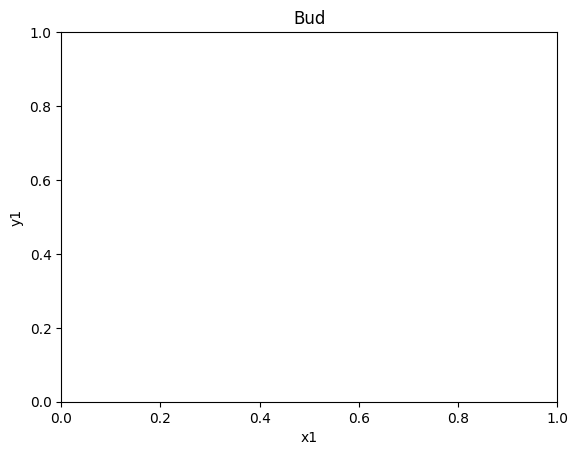

In [325]:
torch.save(model,'Pen_and_Pencil_md.pth')

In [326]:
layer_outputs = {}
def get_layer_output(name):
    """Hook function to store layer output"""
    def hook(model, input, output):
        layer_outputs[name] = output.detach()
    return hook

In [327]:
# Test
# Calculate multi-label metrics properly
def test_model(model, test_loader, print_samples=5):
    model.eval()

    # Initialize counters
    true_positives = torch.zeros(2).to(device)  # For Pen and Pencil
    false_positives = torch.zeros(2).to(device)
    false_negatives = torch.zeros(2).to(device)
    exact_matches = 0
    total_samples = 0

    # For sample printing
    samples_shown = 0
    class_names = ['Pen', 'Pencil']

    print("\nTesting model...")
    print("-" * 50)

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted = (outputs > 0.5).float()

            # Update statistics
            true_positives += (predicted * labels).sum(dim=0)
            false_positives += (predicted * (1 - labels)).sum(dim=0)
            false_negatives += ((1 - predicted) * labels).sum(dim=0)

            # Exact match ratio
            exact_matches += (predicted == labels).all(dim=1).sum().item()
            total_samples += labels.size(0)

            # Print sample predictions
            if samples_shown < print_samples:
                for i in range(labels.size(0)):
                    if samples_shown >= print_samples:
                        break

                    true_labels = [class_names[j] for j in range(2) if labels[i][j] == 1]
                    pred_labels = [class_names[j] for j in range(2) if predicted[i][j] == 1]

                    correct_str = "✓" if (predicted[i] == labels[i]).all() else "✗"
                    print(f"  {correct_str} Pred: {', '.join(pred_labels):<15} (True: {', '.join(true_labels)})")
                    samples_shown += 1

    # Calculate metrics
    precision = true_positives / (true_positives + false_positives + 1e-10)
    recall = true_positives / (true_positives + false_negatives + 1e-10)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)

    exact_match_accuracy = 100. * exact_matches / total_samples

    print("\nClass-wise Performance:")
    print("-" * 50)
    for i in range(2):
        print(f"{class_names[i]:<15}")
        print(f"  Precision: {precision[i].item()*100:.2f}%")
        print(f"  Recall:    {recall[i].item()*100:.2f}%")
        print(f"  F1 Score:  {f1[i].item()*100:.2f}%")
        print("-" * 50)

    print(f"\nExact Match Accuracy: {exact_match_accuracy:.2f}%")
    print(f"(Percentage of samples where all labels were predicted correctly)")
    print("-" * 50)

    return {
        'precision': precision.cpu().numpy(),
        'recall': recall.cpu().numpy(),
        'f1': f1.cpu().numpy(),
        'exact_match_accuracy': exact_match_accuracy
    }

In [328]:
# # Test

# def test_model(model, test_loader, print_samples=5):
#     model.eval()
#     class_names = list(test_loader.dataset.dataset.index_to_label.values())
#     num_classes = len(class_names)

#     # Initialize counters
#     class_correct = [0] * num_classes
#     class_total = [0] * num_classes
#     samples_shown = 0

#     print("\nTesting model...")
#     print("-" * 50)

#     with torch.no_grad():
#         for images, labels in test_loader:
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             pred = (outputs > 0.5)

#             # Update statistics
#             for label, prediction in zip(labels, predicted):
#               for i in range(len(label)):
#                   class_total[i] += 1
#                   if i == prediction:
#                       class_correct[i] += 1

#             # Print balanced samples
#             if samples_shown < print_samples:
#                 for i in range(len(images)):
#                     if samples_shown >= print_samples:
#                         break
#                     if class_total[labels[i].item()] <= print_samples//num_classes:
#                         pred_name = class_names[predicted[i].item()]
#                         true_name = class_names[labels[i].item()]
#                         correct_str = "✓" if predicted[i] == labels[i] else "✗"
#                         print(f"  {correct_str} Pred: {pred_name:<15} (True: {true_name})")
#                         samples_shown += 1

#     # Calculate overall and per-class accuracy
#     total_correct = sum(class_correct)
#     total = sum(class_total)
#     overall_accuracy = 100 * total_correct / total

#     print("\nClass-wise Performance:")
#     print("-" * 50)
#     for i in range(num_classes):
#         accuracy = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
#         print(f"{class_names[i]:<15}: {accuracy:.2f}% ({class_correct[i]}/{class_total[i]})")

#     print("-" * 50)
#     print(f"\nOverall Accuracy: {overall_accuracy:.2f}% ({total_correct}/{total})")
#     print("-" * 50)

#     return overall_accuracy

In [329]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score # Import f1_score here

def find_optimal_thresholds(model, val_loader):
    """Find class-specific thresholds that maximize F1 score on validation set"""
    model.eval()
    all_outputs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            all_outputs.append(outputs)
            all_labels.append(labels)

    # Concatenate all validation data
    outputs = torch.cat(all_outputs)
    labels = torch.cat(all_labels)

    # Find best threshold for each class
    optimal_thresholds = []
    for class_idx in range(2):  # For Pen (0) and Pencil (1)
        best_thresh = 0.5
        best_f1 = 0

        # Test 100 threshold values between 0 and 1
        for thresh in torch.linspace(0, 1, 100):
            preds = (outputs[:, class_idx] > thresh).float()
            # Use the imported f1_score
            f1 = f1_score(labels[:, class_idx].cpu(), preds.cpu())
            if f1 > best_f1:
                best_f1 = f1
                best_thresh = thresh.item()

        optimal_thresholds.append(best_thresh)

    return optimal_thresholds

Epoch: 1 [0/294 (0%)]	Loss: 0.642909

Epoch 1:
Train Loss: 0.6326 | Accuracy: 65.99%
Val Loss: 0.6694 | Accuracy: 53.17%
Validation loss improved. Model saved.
Epoch: 2 [0/294 (0%)]	Loss: 0.540673

Epoch 2:
Train Loss: 0.5958 | Accuracy: 70.41%
Val Loss: 0.7274 | Accuracy: 51.59%
No improvement in validation loss for 1 epochs
Epoch: 3 [0/294 (0%)]	Loss: 0.501048

Epoch 3:
Train Loss: 0.5610 | Accuracy: 72.45%
Val Loss: 0.5813 | Accuracy: 73.02%
Validation loss improved. Model saved.
Epoch: 4 [0/294 (0%)]	Loss: 0.506158

Epoch 4:
Train Loss: 0.5358 | Accuracy: 73.64%
Val Loss: 0.5067 | Accuracy: 79.37%
Validation loss improved. Model saved.
Epoch: 5 [0/294 (0%)]	Loss: 0.517133

Epoch 5:
Train Loss: 0.4982 | Accuracy: 76.36%
Val Loss: 0.4953 | Accuracy: 76.19%
Validation loss improved. Model saved.
Epoch: 6 [0/294 (0%)]	Loss: 0.471807

Epoch 6:
Train Loss: 0.4802 | Accuracy: 77.72%
Val Loss: 0.4446 | Accuracy: 80.95%
Validation loss improved. Model saved.
Epoch: 7 [0/294 (0%)]	Loss: 0.41

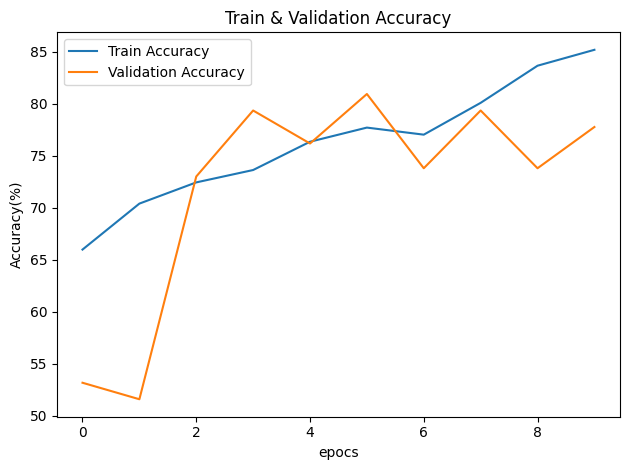

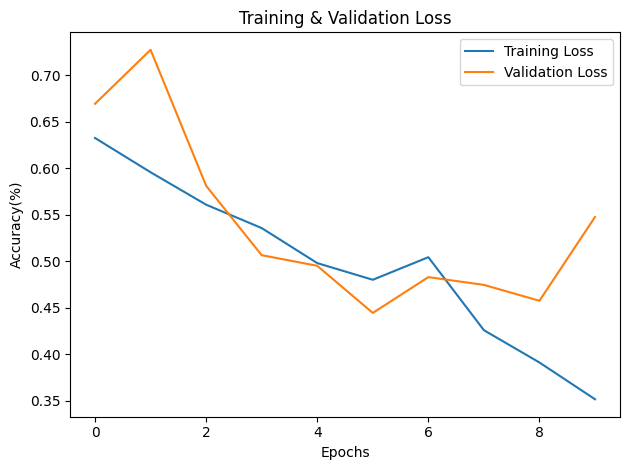

ModelClassifier(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): 

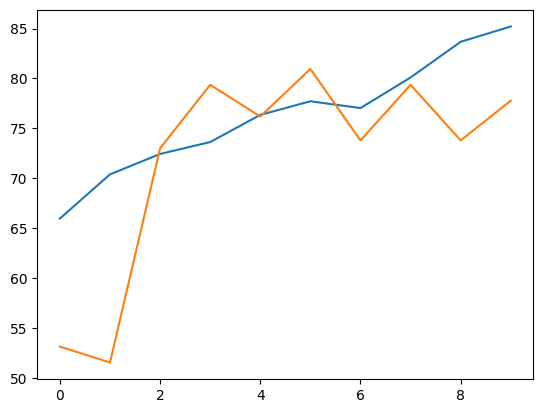

In [352]:
train(model,10)

In [331]:
# from PIL import Image
# import torch
# import torch.nn.functional as F
# import torchvision


# def predict_custom_image(model, image_path, threshold=0.5):
#     """
#     Predict image class(es) for a multi-label model with two outputs (Pen, Pencil).

#     Args:
#         model: Trained PyTorch model
#         image_path: Path to image file
#         threshold: Confidence threshold for considering a label present

#     Returns:
#         dict: {
#             'probabilities': {'Pen': float, 'Pencil': float},
#             'predictions': list of predicted classes,
#             'confidence': average confidence of predicted labels
#         }
#     """
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     model = model.to(device)
#     model.eval()

#     # Preprocessing - MUST MATCH TRAINING PREPROCESSING
#     transform = transforms.Compose([
#         transforms.Grayscale(),
#         transforms.Resize((28, 28)),
#         transforms.ToTensor(),
#         transforms.Normalize((0.5,), (0.5,))
#     ])

#     try:
#         # Load and preprocess image
#         img = Image.open(image_path)
#         img_tensor = transform(img).unsqueeze(0).to(device)

#         # Prediction
#         with torch.no_grad():
#           output = self.model(img_tensor)
#           pen_prob, pencil_prob = output[0][0].item(), output[0][1].item()

#         # Use class-specific thresholds
#         has_pen = pen_prob > self.thresholds[0]
#         has_pencil = pencil_prob > self.thresholds[1]

#         # Print results
#         print("\nPrediction Results:")
#         print("-" * 30)
#         if has_pen and not has_pencil:
#             print("Pen")
#         elif has_pencil and not has_pen:
#             print("Pencil")
#         elif has_pen and has_pencil:
#             print("Pen and Pencil")
#         else:
#             print("Neither Pen nor Pencil")
#         print("-" * 30)
#         print(f"Confidence - Pen: {pen_prob:.2%} (threshold: {self.thresholds[0]:.2f})")
#         print(f"Confidence - Pencil: {pencil_prob:.2%} (threshold: {self.thresholds[1]:.2f})")

#     except Exception as e:
#         raise RuntimeError(f"Prediction failed: {str(e)}")

# Example usage
# Make sure 'dataset' is the ImageFolder instance you want to use for getting class names
# In your setup, 'dataset' is created directly under Custom_DataSet, while test_set is
# created under Custom_DataSet/Test. For prediction on individual images, it's often
# convenient to use a dataset object that reflects the classes you trained on.
# Using 'train_set' or 'test_set' here would also work as they share the same class structure
# derived from the subfolders. Let's use train_set as it's generally available.
# However, the original code uses 'dataset' from the root, which should also work
# if the root contains subfolders corresponding to the classes. Let's stick to 'dataset'
# as per the original error context.

# Ensure the device variable is defined (it is in your global variables)
# device = 'cuda' if torch.cuda.is_available() else 'cpu' # This is defined earlier in your notebook

# Ensure the dataset object is available and correctly instantiated ImageFolder
# dataset = datasets.ImageFolder('/content/Pens_Pencils/Custom_DataSet', transform=transform) # This is defined earlier


In [332]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
from sklearn.metrics import f1_score # Ensure f1_score is imported if find_optimal_thresholds is used

# Assuming device is defined globally as in your original notebook
# device = 'cuda' if torch.cuda.is_available() else 'cpu'

class PenPencilClassifier:
    def __init__(self, model, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device
        self.model = model.to(self.device) # Move model to device once
        self.thresholds = [0.5, 0.5]  # Defaults before tuning
        self.class_names = ['Pen', 'Pencil']

        # Define the transformation here to reuse it
        self.transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize((28, 28)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

    def tune_thresholds(self, val_loader):
        # Ensure find_optimal_thresholds is accessible and works with self.model and val_loader
        # Assuming find_optimal_thresholds is defined elsewhere and accepts model and loader
        self.thresholds = find_optimal_thresholds(self.model, val_loader)
        print(f"Optimized thresholds - Pen: {self.thresholds[0]:.2f}, Pencil: {self.thresholds[1]:.2f}")

    def predict(self, image_path):
        self.model.eval() # Set model to evaluation mode

        try:
            # Load and preprocess image using the stored transform
            img = Image.open(image_path)
            # Apply the transformation and add a batch dimension, then move to device
            img_tensor = self.transform(img).unsqueeze(0).to(self.device)

            with torch.no_grad():
                # Pass the preprocessed image tensor through the model
                output = self.model(img_tensor)
                # Get probabilities for each class
                pen_prob, pencil_prob = output[0][0].item(), output[0][1].item()

            # Use class-specific thresholds for prediction
            has_pen = pen_prob > 0.5
            has_pencil = pencil_prob > 0.5

            # Print prediction results
            print("\nPrediction Results:")
            print("-" * 30)
            predicted_labels = []
            if has_pen:
                predicted_labels.append("Pen")
            if has_pencil:
                predicted_labels.append("Pencil")

            if not predicted_labels:
                 print("Neither Pen nor Pencil")
            else:
                 print(" and ".join(predicted_labels))

            print("-" * 30)
            print(f"Confidence - Pen: {pen_prob:.2%} ")
            print(f"Confidence - Pencil: {pencil_prob:.2%}")

        except FileNotFoundError:
            print(f"Error: Image file not found at {image_path}")
        except Exception as e:
            print(f"An error occurred during prediction: {e}")

# Note: The find_optimal_thresholds function needs to be defined before PenPencilClassifier is used.
# Make sure the definition of find_optimal_thresholds in your notebook is correct and accessible.
# The provided definition of find_optimal_thresholds in ipython-input-462-28c67673e62b looks correct.

In [333]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image

# Define a dictionary to store layer outputs
layer_outputs = {}

def get_layer_output(name):
    """Hook function to store layer output"""
    def hook(model, input, output):
        layer_outputs[name] = output.detach()
    return hook

def predict_with_debug(model, image_path, class_names):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    # Register hooks for all layers
    hooks = []
    for name, layer in model.named_children():
        hook = layer.register_forward_hook(get_layer_output(name))
        hooks.append(hook)

    # Preprocess image
    transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    img = Image.open(image_path)
    img_tensor = transform(img).unsqueeze(0).to(device)

    # Forward pass (captures all layer outputs in `layer_outputs`)
    with torch.no_grad():
        output = model(img_tensor)
        probs = torch.nn.functional.softmax(output[0], dim=0)
        conf, pred_idx = torch.max(probs, 0)

    # Remove hooks
    for hook in hooks:
        hook.remove()

    # Print layer outputs (for debugging)
    for name, output in layer_outputs.items():
        print(f"Layer: {name}")
        print(f"Shape: {output.shape}")
        print(f"Min: {output.min().item()}, Max: {output.max().item()}")
        print("-" * 50)

    # Return prediction results
    all_probs = {class_names[i]: f"{probs[i].item()*100:.1f}%"
                for i in range(len(class_names))}
    return class_names[pred_idx], conf.item(), all_probs

In [334]:
test_model(model,test_loader)


Testing model...
--------------------------------------------------
  ✓ Pred: Pen, Pencil     (True: Pen, Pencil)
  ✓ Pred: Pen             (True: Pen)
  ✓ Pred: Pen, Pencil     (True: Pen, Pencil)
  ✗ Pred: Pen             (True: Pen, Pencil)
  ✓ Pred: Pencil          (True: Pencil)

Class-wise Performance:
--------------------------------------------------
Pen            
  Precision: 87.76%
  Recall:    95.56%
  F1 Score:  91.49%
--------------------------------------------------
Pencil         
  Precision: 82.35%
  Recall:    73.68%
  F1 Score:  77.78%
--------------------------------------------------

Exact Match Accuracy: 69.84%
(Percentage of samples where all labels were predicted correctly)
--------------------------------------------------


{'precision': array([0.877551 , 0.8235294], dtype=float32),
 'recall': array([0.95555556, 0.7368421 ], dtype=float32),
 'f1': array([0.9148937, 0.7777778], dtype=float32),
 'exact_match_accuracy': 69.84126984126983}

In [335]:
import matplotlib.pyplot as plt

def create_multilabel_confusion_matrix(model, test_loader, class_names, device, threshold=0.5):
    """
    Create a confusion matrix for multi-label classification.

    Args:
        model: Your trained model
        test_loader: DataLoader for test data
        class_names: List of class names (e.g., ['pen', 'pencil', 'both'])
        device: Device to run computations on
        threshold: Threshold for considering a prediction positive
    """
    model.eval()
    num_classes = len(class_names)

    # Initialize confusion matrices (one per class)
    confusion_matrices = {
        'tp': torch.zeros(num_classes),
        'fp': torch.zeros(num_classes),
        'fn': torch.zeros(num_classes),
        'tn': torch.zeros(num_classes)
    }

    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            labels = labels.to(device)

            outputs = model(data)
            preds = (outputs > threshold).float()

            # For each class, calculate TP, FP, FN, TN
            for i in range(num_classes):
                true_pos = (labels[:, i] == 1) & (preds[:, i] == 1)
                false_pos = (labels[:, i] == 0) & (preds[:, i] == 1)
                false_neg = (labels[:, i] == 1) & (preds[:, i] == 0)
                true_neg = (labels[:, i] == 0) & (preds[:, i] == 0)

                confusion_matrices['tp'][i] += true_pos.sum().item()
                confusion_matrices['fp'][i] += false_pos.sum().item()
                confusion_matrices['fn'][i] += false_neg.sum().item()
                confusion_matrices['tn'][i] += true_neg.sum().item()

    # Plot individual confusion matrices for each class
    fig, axes = plt.subplots(1, num_classes, figsize=(5*num_classes, 5))

    for i, class_name in enumerate(class_names):
        ax = axes[i] if num_classes > 1 else axes
        cm = torch.tensor([
            [confusion_matrices['tp'][i], confusion_matrices['fn'][i]],
            [confusion_matrices['fp'][i], confusion_matrices['tn'][i]]
        ])

        # Normalize
        cm_normalized = cm / cm.sum()

        # Plot
        im = ax.imshow(cm_normalized.numpy(), interpolation='nearest', cmap=plt.cm.Blues)
        ax.set_title(f'Class: {class_name}')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        ax.set_xticklabels(['Positive', 'Negative'])
        ax.set_yticklabels(['Positive', 'Negative'])

        # Add text annotations
        thresh = cm_normalized.max() / 2.
        for x in range(2):
            for y in range(2):
                ax.text(x, y, f"{cm[y, x]:.0f}\n({cm_normalized[y, x]*100:.1f}%)",
                       horizontalalignment="center",
                       color="white" if cm_normalized[y, x] > thresh else "black")

    plt.tight_layout()
    plt.show()

    return confusion_matrices

In [336]:
#(model,test_loader=test_loader,num_classes=num_classes,device=device)

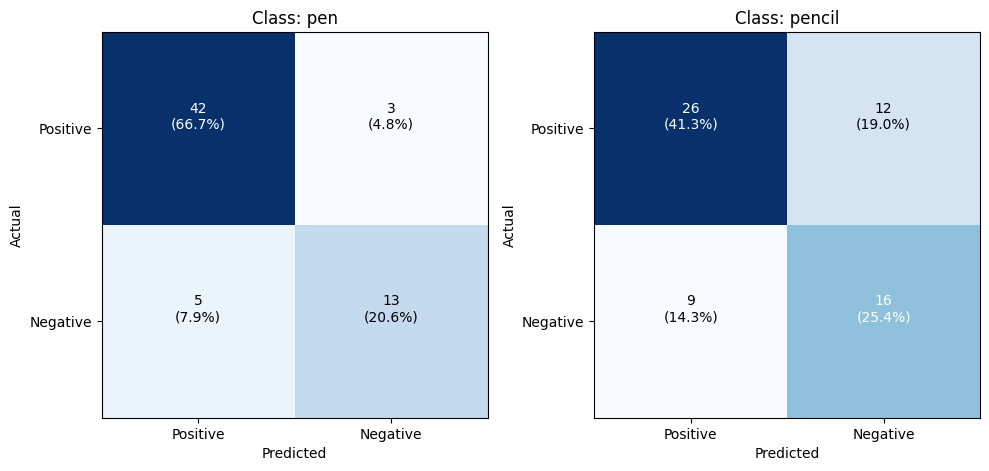

In [337]:
class_names = ['pen', 'pencil']
confusion_matrices = create_multilabel_confusion_matrix(
    model,
    test_loader,
    class_names,
    device=device,
    threshold=0.5
)


In [338]:
predictions = PenPencilClassifier(model)
predictions.tune_thresholds(val_loader)

Optimized thresholds - Pen: 0.68, Pencil: 0.33


In [339]:
# Example usage
predictions.predict("/content/pencil_280523090.jpg")



Prediction Results:
------------------------------
Neither Pen nor Pencil
------------------------------
Confidence - Pen: 46.03% 
Confidence - Pencil: 20.49%


In [340]:
# Example usage
predictions.predict( "/content/Example_1.jpg")



Prediction Results:
------------------------------
Pen
------------------------------
Confidence - Pen: 99.89% 
Confidence - Pencil: 4.42%


In [341]:
# Example usage
predictions.predict( "/content/Example_2.png")




Prediction Results:
------------------------------
Pen and Pencil
------------------------------
Confidence - Pen: 98.82% 
Confidence - Pencil: 97.86%


In [342]:
# Example usage
predictions.predict( "/content/71uPkyrlipL.jpg")




Prediction Results:
------------------------------
Pen
------------------------------
Confidence - Pen: 100.00% 
Confidence - Pencil: 1.24%


In [343]:
# Example usage
predictions.predict( "/content/ue2ilgr1xau21.jpg")




Prediction Results:
------------------------------
Pen and Pencil
------------------------------
Confidence - Pen: 95.77% 
Confidence - Pencil: 96.26%


In [344]:
# Example usage
predictions.predict("/content/51TkKa5QdgL.jpg")




Prediction Results:
------------------------------
Pen
------------------------------
Confidence - Pen: 97.62% 
Confidence - Pencil: 1.49%


In [345]:
# Example usage
example_classes = test_loader.dataset.classes

pred_class, confidence, all_probs = predict_custom_image(
            model=model,
            image_path='/content/TTT.jpg',
            class_names=example_classes
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")


AttributeError: 'Subset' object has no attribute 'classes'

In [ ]:
# Example usage
example_classes = test_loader.dataset.classes

pred_class, confidence, all_probs = predict_custom_image(
            model=model,
            image_path='/content/71uPkyrlipL.jpg',
            class_names=example_classes
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")
